In [52]:
from testproblems import generate_random_prob, random_problem_with_artifacts
from datastructures.operators import invert_edges, sort_scc, reformulate
from datastructures.rendering import render_incidence
from datastructures.tearing import min_arc_set_assign,dir_graph,min_max_scc2
from datastructures.graphutils import (edges_to_Ein_Eout, sources, flat_graph_formulation, 
    VAR, COMP, Node, all_edges)
from datastructures.polycasebuilder import eqv_to_edges_tree
import networkx as nx
import numpy as np
from itertools import chain, combinations

In [206]:
m = 10#4
n = 15#5
seed = 220#257#23
sparsity = 1.

In [207]:
kwargs = random_problem_with_artifacts(m,n,seed,sparsity)

In [208]:
eq_incidence,outset,eqnidxs,edges_varonleft,varidxs = map(kwargs.get, ["eq_incidence","outset","eqnidxs","edges_varonleft","varidxs"])

In [201]:
fixed_inputs = set(range(m,m+n))-set(outset.values())

In [176]:
fixed_inputs = list(combinations(range(n), n-m))[330]

In [155]:
fixed_inputs = tuple(elt+m for elt in fixed_inputs)

In [164]:
fixed_inputs = {10,14,21,23,24}

In [212]:
maxscc = []
for fixed_inputs in combinations(range(n), n-m):
    fixed_inputs = tuple(elt+m for elt in fixed_inputs)
    Ein_no_source = {comp:tuple(var for var in allvars if var not in fixed_inputs) for comp,allvars in eq_incidence.items()}
    G = flat_graph_formulation(Ein_no_source,{},{},{VAR: 'x_{{{}}}', COMP: 'f_{{{}}}'})
    top_nodes = {Node(idx, VAR) for idx in varidxs if idx not in fixed_inputs}
    matching = nx.bipartite.maximum_matching(G, top_nodes=top_nodes)
    if len(matching) == 2*m:
        m_out = {key: matching[Node(key, COMP)].name for key in eqnidxs}
        edges_dir_m = invert_edges(eq_incidence, newout=m_out)
        dir_edges = all_edges(*edges_dir_m)
        maxscc_idx = max(len(elt) for elt in nx.strongly_connected_components(nx.DiGraph(dir_edges)))//2
        maxscc.append(maxscc_idx)

In [214]:
len(np.argwhere(np.array(maxscc)==0))

224

In [209]:
edges_undir,tree_undir,_ = eqv_to_edges_tree(eq_incidence, n_eqs=m)
edges_dir,tree_dir,outset_adj = eqv_to_edges_tree(eq_incidence, outset, n_eqs=m)
tree_undir[2].update({val:1 for val in outset_adj.values()})

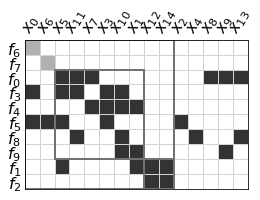

In [210]:
formulation_scc = reformulate(edges_dir, tree_dir, root_solver_name=1, mdf=True)
render_incidence(*formulation_scc, figsize=((4,4)), rotation=60, hideticks=True,);

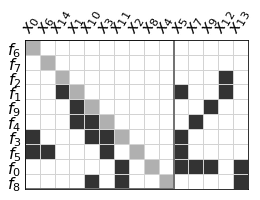

In [211]:
xsol, model = min_max_scc2(edges_varonleft, varidxs, eqnidxs)
outset_minscc = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
formulation_minscc = reformulate(edges_dir, tree_dir, outset_adj, outset_minscc, root_solver_name=1)
render_incidence(*formulation_minscc, figsize=((4,4)), hideticks=True);